In [1]:
pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 54.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 5.1 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592287 sha256=6601d729b9197bbd405a1e1d8dbf9b1f9ad4c6e8c8cc8bd167109ecd2f767800
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf

In [7]:
import numpy as np
import librosa
import pretty_midi
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model

class MusicTranscriber:
    def __init__(self, sr=22050, hop_length=512, n_bins=84, bins_per_octave=12):
        self.sr = sr
        self.hop_length = hop_length
        self.n_bins = n_bins
        self.bins_per_octave = bins_per_octave
        self.fs = sr / hop_length  # Frame rate for piano roll alignment
        # Calculate sequence_length based on 3 minutes duration
        self.standard_duration = 180  # 3 minutes in seconds
        self.sequence_length = int(np.ceil(self.standard_duration * self.fs))  # Number of frames

    def process_audio(self, audio_path):
        # Load audio file (up to 3 minutes)
        y, _ = librosa.load(audio_path, sr=self.sr, duration=self.standard_duration)
        # Compute CQT
        C = librosa.cqt(
            y,
            sr=self.sr,
            hop_length=self.hop_length,
            n_bins=self.n_bins,
            bins_per_octave=self.bins_per_octave
        )
        # Convert to magnitude and apply log scaling
        C_mag = librosa.amplitude_to_db(np.abs(C), ref=np.max)
        # Pad or truncate to fixed length
        if C_mag.shape[1] < self.sequence_length:
            pad_width = ((0, 0), (0, self.sequence_length - C_mag.shape[1]))
            C_mag = np.pad(C_mag, pad_width, mode='constant')
        else:
            C_mag = C_mag[:, :self.sequence_length]
        return C_mag

    def process_midi(self, midi_path):
        midi_data = pretty_midi.PrettyMIDI(midi_path)
        end_time = self.standard_duration  # Use standard duration
        # Generate time frames matching the spectrogram
        times = np.linspace(0, end_time, self.sequence_length)
        piano_roll = midi_data.get_piano_roll(fs=self.fs, times=times)
        # Restrict to MIDI note range 21–108 (88 keys)
        piano_roll = piano_roll[21:109, :]  # MIDI note numbers 21–108 inclusive
        # Ensure fixed length
        if piano_roll.shape[1] < self.sequence_length:
            pad_width = ((0, 0), (0, self.sequence_length - piano_roll.shape[1]))
            piano_roll = np.pad(piano_roll, pad_width, mode='constant')
        else:
            piano_roll = piano_roll[:, :self.sequence_length]
        # Normalize to binary values
        piano_roll = (piano_roll > 0).astype(np.float32)
        return piano_roll

    def create_model(self, input_shape, n_pitches):
        # Input layer
        inputs = layers.Input(shape=input_shape)

        # First Convolutional Block
        x = layers.Conv2D(32, (3, 3), padding='same')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.MaxPooling2D((2, 1))(x)  # Frequency dimension reduced from 84 to 42

        # Second Convolutional Block
        x = layers.Conv2D(64, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        # No pooling here; frequency dimension remains at 42

        # Reshape for LSTM layer
        x = layers.Permute((2, 1, 3))(x)  # Shape: (batch_size, 512, 42, 64)

        # Correct `new_height` calculation
        new_height = input_shape[0] // 2  # 84 // 2 = 42

        # Reshape to (batch_size, time_steps, new_height * channels)
        x = layers.Reshape((x.shape[1], new_height * 64))(x)  # Shape: (batch_size, 512, 2688)

        # Bidirectional LSTM layers
        x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
        x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)

        # Output layer
        outputs = layers.TimeDistributed(layers.Dense(n_pitches, activation='sigmoid'))(x)

        # Create and return the model
        model = Model(inputs=inputs, outputs=outputs)
        return model



    def prepare_dataset(self, audio_files, midi_files):
        spectrograms = []
        piano_rolls = []
        for audio_path, midi_path in zip(audio_files, midi_files):
            try:
                # Process audio
                cqt = self.process_audio(audio_path)
                # Process MIDI
                piano_roll = self.process_midi(midi_path)
                spectrograms.append(cqt)
                piano_rolls.append(piano_roll)
            except Exception as e:
                print(f"Error processing {audio_path}: {str(e)}")
                continue
        # Stack arrays
        X = np.stack(spectrograms)
        y = np.stack(piano_rolls)
        # Add channel dimension for CNN
        X = X[..., np.newaxis]  # Shape: (batch_size, n_bins, time_steps, 1)
        # Transpose y to have shape (batch_size, time_steps, n_pitches)
        y = y.transpose(0, 2, 1)
        return X, y

def segment_data(X, y, segment_length=512, hop_length=256):
    X_segments = []
    y_segments = []
    for i in range(X.shape[0]):  # Iterate over samples
        max_time = X.shape[2]  # Time dimension
        for start in range(0, max_time - segment_length + 1, hop_length):
            end = start + segment_length
            X_segments.append(X[i, :, start:end, :])
            y_segments.append(y[i, start:end, :])
    X_segments = np.array(X_segments)
    y_segments = np.array(y_segments)
    return X_segments, y_segments

print("Updated MusicTranscriber class defined successfully")

# Instantiate the class
transcriber = MusicTranscriber()

# Define your audio_files and midi_files lists
audio_files = [f"/content/drive/MyDrive/CS 5100 Project/MT Dataset/maestro/Track00{i}.wav" for i in range(1, 48)]
midi_files = [f"/content/drive/MyDrive/CS 5100 Project/MT Dataset/maestro/Track00{i}.midi" for i in range(1, 48)]

# Prepare the dataset
spectrograms, piano_rolls = transcriber.prepare_dataset(audio_files, midi_files)
print(f"Spectrograms shape: {spectrograms.shape}")
print(f"Piano rolls shape: {piano_rolls.shape}")

# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(spectrograms, piano_rolls, test_size=0.2, random_state=42)


Updated MusicTranscriber class defined successfully
Spectrograms shape: (47, 84, 7752, 1)
Piano rolls shape: (47, 7752, 88)


In [26]:
import tensorflow.keras.backend as K

def focal_loss(alpha=0.35, gamma=3.0):
    def focal_loss_with_logits(y_true, y_pred):
        # Compute cross entropy loss
        bce = K.binary_crossentropy(y_true, y_pred)
        # Compute the modulating factor
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        modulating_factor = K.pow(1.0 - p_t, gamma)
        # Apply alpha weighting
        alpha_weight_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        # Compute focal loss
        loss = alpha_weight_factor * modulating_factor * bce
        return K.mean(loss)
    return focal_loss_with_logits


class PianoRollPrecision(tf.keras.metrics.Metric):
    def __init__(self, threshold=0.5, name='piano_roll_precision', **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)

        true_positives = tf.reduce_sum(y_true * y_pred)
        false_positives = tf.reduce_sum((1 - y_true) * y_pred)

        self.true_positives.assign_add(true_positives)
        self.false_positives.assign_add(false_positives)

    def result(self):
        return self.true_positives / (self.true_positives + self.false_positives + K.epsilon())

    def reset_state(self):
        self.true_positives.assign(0.)
        self.false_positives.assign(0.)

class PianoRollRecall(tf.keras.metrics.Metric):
    def __init__(self,threshold=0.5, name='piano_roll_recall', **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)

        true_positives = tf.reduce_sum(y_true * y_pred)
        false_negatives = tf.reduce_sum(y_true * (1 - y_pred))

        self.true_positives.assign_add(true_positives)
        self.false_negatives.assign_add(false_negatives)

    def result(self):
        return self.true_positives / (self.true_positives + self.false_negatives + K.epsilon())

    def reset_state(self):
        self.true_positives.assign(0.)
        self.false_negatives.assign(0.)

class PianoRollF1Score(tf.keras.metrics.Metric):
    def __init__(self, name='piano_roll_f1', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = PianoRollPrecision()
        self.recall = PianoRollRecall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + K.epsilon()))

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()


# Segment the data
segment_length = 512
hop_length = 256
X_train_seg, y_train_seg = segment_data(X_train, y_train, segment_length, hop_length)
X_val_seg, y_val_seg = segment_data(X_val, y_val, segment_length, hop_length)

print(f"Segmented X_train shape: {X_train_seg.shape}")
print(f"Segmented y_train shape: {y_train_seg.shape}")

# Create the model
input_shape = X_train_seg.shape[1:]  # (n_bins, segment_length, 1)
n_pitches = y_train_seg.shape[2]     # Should be 88 (number of pitches)

model = transcriber.create_model(input_shape, n_pitches)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(optimizer=optimizer, loss=focal_loss(alpha=0.35, gamma=4.0), metrics=[PianoRollPrecision(0.4), PianoRollRecall(0.4), PianoRollF1Score()])

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
]

history = model.fit(
    X_train_seg, y_train_seg,
    validation_data=(X_val_seg, y_val_seg),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=callbacks
)




Segmented X_train shape: (1073, 84, 512, 1)
Segmented y_train shape: (1073, 512, 88)
Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 46s 582ms/step - loss: 0.0114 - piano_roll_f1: 0.0627 - piano_roll_precision: 0.0694 - piano_roll_recall: 0.2534 - val_loss: 0.0060 - val_piano_roll_f1: 0.0000e+00 - val_piano_roll_precision: 0.0887 - val_piano_roll_recall: 0.0200
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 426ms/step - loss: 0.0066 - piano_roll_f1: 3.3176e-07 - piano_roll_precision: 0.1839 - piano_roll_recall: 0.0140 - val_loss: 0.0059 - val_piano_roll_f1: 0.0000e+00 - val_piano_roll_precision: 0.2103 - val_piano_roll_recall: 0.0029
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 432ms/step - loss: 0.0062 - piano_roll_f1: 6.2817e-05 - piano_roll_precision: 0.3220 - piano_roll_recall: 0.0960 - val_loss: 0.0056 - val_piano_roll_f1: 6.3995e-04 - val_piano_roll_precision: 0.2602 - val_piano_roll_recall: 0.3404
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 428ms/step - loss: 0.0056 - piano_roll_f1: 0.0184 - piano_

In [30]:
model.save('piano_transcriberF1.h5')
model.save('piano_transcriberF1.keras')

In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_sparse_piano_roll(y_true, y_pred, epsilon=1e-7):
    # Flatten y_true and y_pred to 1D arrays
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Identify active regions (where either y_true or y_pred is positive)
    active_regions = (y_true_flat > 0) | (y_pred_flat > 0)

    # Calculate standard metrics on active regions
    precision = precision_score(y_true_flat[active_regions], y_pred_flat[active_regions], zero_division=0)
    recall = recall_score(y_true_flat[active_regions], y_pred_flat[active_regions], zero_division=0)
    f1 = f1_score(y_true_flat[active_regions], y_pred_flat[active_regions], zero_division=0)

    # Custom metric: Note-wise accuracy (focusing on active notes)
    true_positives = np.sum((y_true_flat == 1) & (y_pred_flat == 1))
    false_positives = np.sum((y_true_flat == 0) & (y_pred_flat == 1))
    false_negatives = np.sum((y_true_flat == 1) & (y_pred_flat == 0))

    note_precision = true_positives / (true_positives + false_positives + epsilon)
    note_recall = true_positives / (true_positives + false_negatives + epsilon)
    note_f1 = 2 * (note_precision * note_recall) / (note_precision + note_recall + epsilon)

    return {
        'active_precision': precision,
        'active_recall': recall,
        'active_f1': f1,
        'note_precision': note_precision,
        'note_recall': note_recall,
        'note_f1': note_f1
    }


In [32]:
def evaluate_framewise_piano_roll(y_true, y_pred, epsilon=1e-7):
    # Flatten y_true and y_pred to 1D arrays
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Calculate standard metrics for the entire dataset (not limited to active regions)
    precision = precision_score(y_true_flat, y_pred_flat, zero_division=0)
    recall = recall_score(y_true_flat, y_pred_flat, zero_division=0)
    f1 = f1_score(y_true_flat, y_pred_flat, zero_division=0)

    return {
        'frame_precision': precision,
        'frame_recall': recall,
        'frame_f1': f1
    }


In [33]:
# Generate predictions
predictions = model.predict(X_val_seg)  # Shape: (num_samples, time_steps, n_pitches)

# Threshold to get binary predictions
threshold = 0.5
binary_predictions = (predictions > threshold).astype(np.float32)

def evaluate_all_metrics(y_true, y_pred, epsilon=1e-7):
    # Flatten y_true and y_pred
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Framewise metrics
    frame_metrics = evaluate_framewise_piano_roll(y_true, y_pred)

    # Note-wise metrics (your existing implementation)
    note_metrics = evaluate_sparse_piano_roll(y_true, y_pred, epsilon)

    # Combine results
    return {**frame_metrics, **note_metrics}


metrics = evaluate_all_metrics(y_val_seg, binary_predictions)

# Print the results
print("Evaluation Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step
Evaluation Metrics:
frame_precision: 0.7632
frame_recall: 0.5408
frame_f1: 0.6330
active_precision: 0.7632
active_recall: 0.5408
active_f1: 0.6330
note_precision: 0.7632
note_recall: 0.5408
note_f1: 0.6330


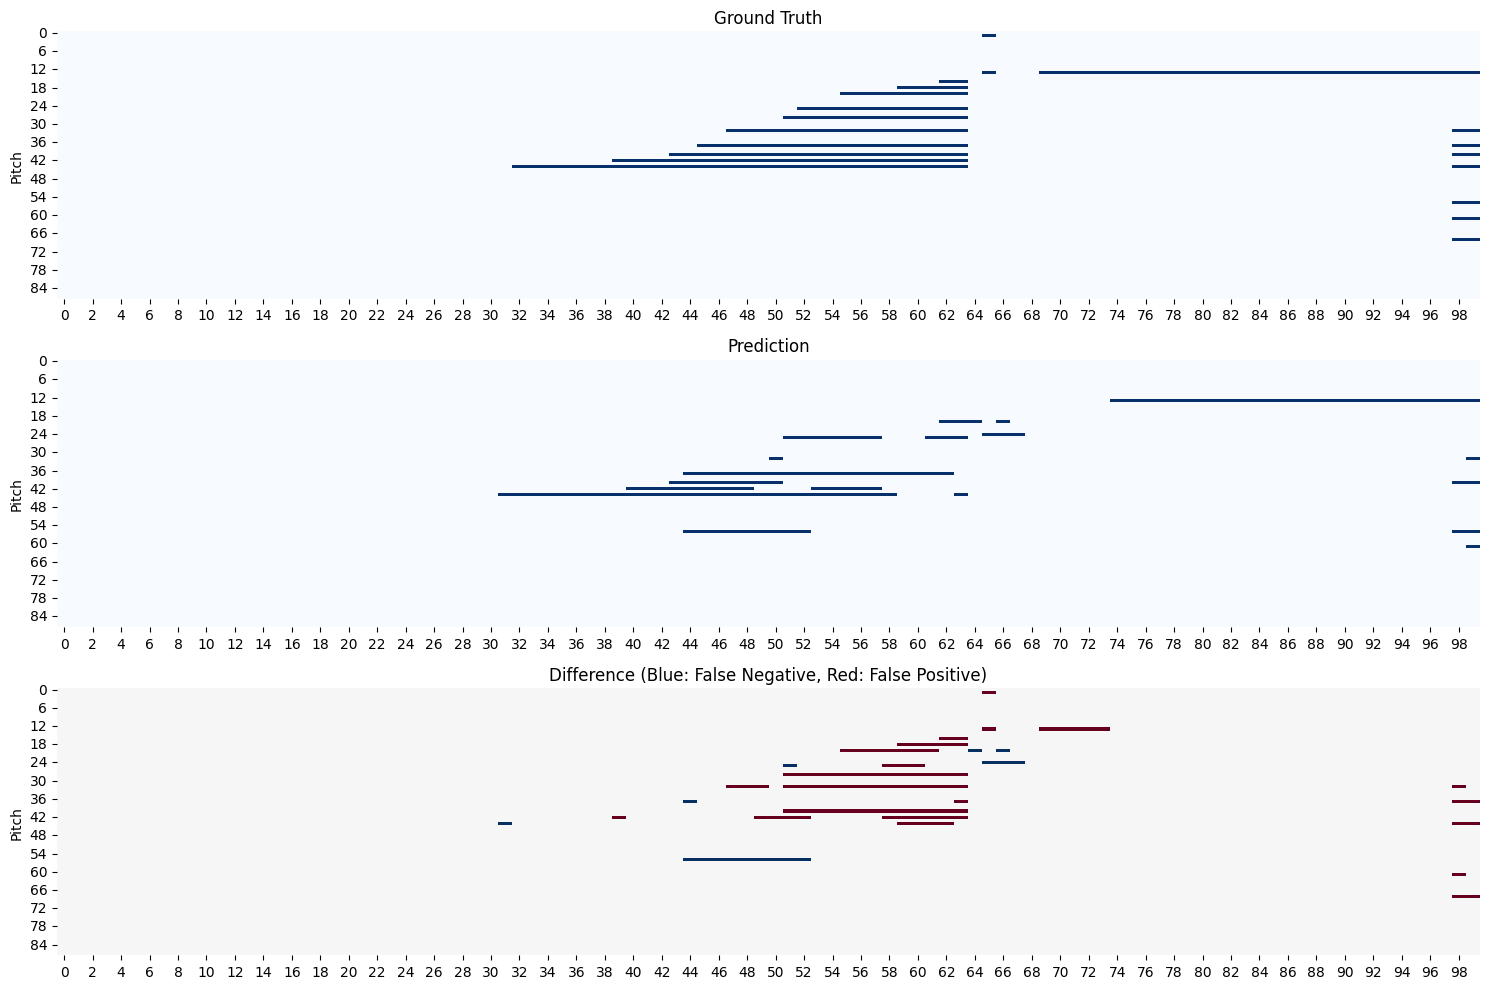

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_comparison(y_true, y_pred, sample_idx=0, start_idx=0, length=100):
    """Visualize a segment of the piano roll comparison for a specific sample."""
    # Extract the sample
    y_true_sample = y_true[sample_idx]  # Shape: (time_steps, n_pitches)
    y_pred_sample = y_pred[sample_idx]

    # Select the segment
    y_true_segment = y_true_sample[start_idx:start_idx+length]
    y_pred_segment = y_pred_sample[start_idx:start_idx+length]

    # Compute the difference
    difference = y_true_segment - y_pred_segment

    # Plotting
    fig, axes = plt.subplots(3, 1, figsize=(15, 10))

    sns.heatmap(y_true_segment.T, ax=axes[0], cmap='Blues', cbar=False)
    axes[0].set_title('Ground Truth')
    axes[0].set_ylabel('Pitch')

    sns.heatmap(y_pred_segment.T, ax=axes[1], cmap='Blues', cbar=False)
    axes[1].set_title('Prediction')
    axes[1].set_ylabel('Pitch')

    sns.heatmap(difference.T, ax=axes[2], cmap='RdBu_r', center=0, cbar=False)
    axes[2].set_title('Difference (Blue: False Negative, Red: False Positive)')
    axes[2].set_ylabel('Pitch')

    plt.tight_layout()
    plt.show()


visualize_comparison(y_val_seg, binary_predictions, sample_idx=0, start_idx=0, length=100)
